In [1]:
import numpy as np
import great_expectations as ge
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import json
%matplotlib inline

In [2]:
## In the given problem, we expect that we have discrete values in the range 1-100 with a mean that is usually
## somewhat less than 50 and very fat tails.

# We choose the beta distribution with scale to provide a sample of data for this notebook, but real data
# would of coure be preferable and would allow the same procedure

a = np.random.uniform(1, 1.5, size=10)
b = np.random.uniform(1, 1.5, size=10)

beta = []
for k in range(len(a)):
    beta.append(np.round(np.random.beta(a[k], b[k], size=10000)*100))

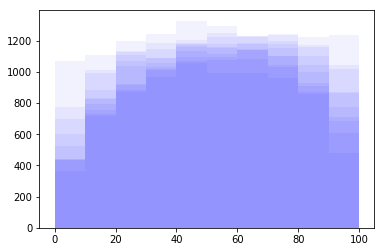

In [3]:
# Review the data manually

for k in range(10):
    plt.hist(beta[k], alpha=0.05, color='blue')

In [4]:
# Compute a partition object as the "mean" empirical distribution we created
# mean_hist = np.histogram(np.array(beta), bins=range(0, 101, 10))
mean_hist = np.histogram(np.array(beta), bins=range(0, 101))

In [5]:
# I think it is often useful to sanity check our partition object. We can also use the ge.dataset.util method
# is_valid_partition_object

partition_object = {
    'weights': mean_hist[0] / 100000,
    'values': mean_hist[1][1:]
}
partition_object

{'weights': array([0.00137, 0.00436, 0.005  , 0.00626, 0.00596, 0.00618, 0.00665,
        0.00706, 0.00738, 0.00757, 0.00776, 0.00783, 0.00812, 0.00837,
        0.00883, 0.00934, 0.00877, 0.00911, 0.00873, 0.00962, 0.00957,
        0.01037, 0.00945, 0.01047, 0.01044, 0.00985, 0.01011, 0.01049,
        0.0107 , 0.01118, 0.01009, 0.01096, 0.01127, 0.01147, 0.01044,
        0.01058, 0.01097, 0.01054, 0.01106, 0.01103, 0.01124, 0.01167,
        0.01133, 0.01152, 0.01165, 0.01169, 0.01184, 0.01119, 0.0119 ,
        0.01185, 0.01153, 0.01186, 0.01105, 0.01217, 0.01176, 0.01151,
        0.01073, 0.01192, 0.01125, 0.01167, 0.01178, 0.01154, 0.01102,
        0.01205, 0.01147, 0.01228, 0.01163, 0.01135, 0.01136, 0.01095,
        0.01132, 0.01119, 0.01089, 0.01184, 0.01139, 0.01101, 0.01128,
        0.01085, 0.0111 , 0.01146, 0.01009, 0.01023, 0.01101, 0.01031,
        0.01078, 0.01057, 0.00978, 0.01012, 0.0099 , 0.00985, 0.00935,
        0.00938, 0.00863, 0.00869, 0.0091 , 0.00789, 0.00799, 0.00

In [6]:
len(partition_object['values'])

100

In [7]:
# We'll now repeat the sampling process to demonstrate data that passes our expectation,
# and as a mechanism to simply create a collection of (in this case identical) expectations

a_prime = np.random.uniform(1, 1.5, size=10)
b_prime = np.random.uniform(1, 1.5, size=10)

beta_prime = {}
for k in range(len(a_prime)):
    beta_prime[str(k)] = np.ceil(np.random.beta(a_prime[k], b_prime[k], size=1000)*100)

In [8]:
df = ge.dataset.PandasDataset(beta_prime)

In [9]:
## Note the threshold selection is effectively a tunable parameter to dial precision/recall

res = ge.dataset.util.create_multiple_expectations(
    df,
    [str(k) for k in range(10)],
    'expect_column_kl_divergence_to_be_less_than',
    partition_object=partition_object,
    threshold=0.1
)

# Note the threshold we're observing even on our "expected" data.
# If we could define our expected data more precisely we could also use that as a means to tune of course
np.array([x["result"]["observed_value"] for x in res]).mean()

0.06501235847413495

In [10]:
# Finally, we repeat the process but adjust the data generating process to include an error (double counting)
# a subset of the data.

a_prime = np.random.uniform(1, 1.5, size=10)
b_prime = np.random.uniform(1, 1.5, size=10)

beta_prime_broken  = {}
for k in range(len(a_prime)):
    beta_vals = np.ceil(np.random.beta(a_prime[k], b_prime[k], size=1000)*100)
    # In the estimated error condition, we observed extremely high counts for some value
    # (because it was being multiply counted)
    miscount_vals = np.array([39] * 100)
    vals = np.append(beta_vals, miscount_vals)
    beta_prime_broken[str(k)] = vals

In [11]:
df_broken = ge.dataset.PandasDataset(beta_prime_broken)

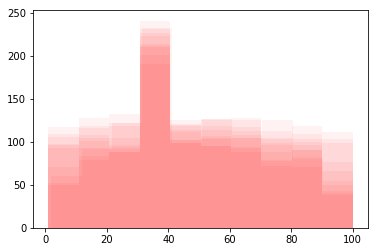

In [12]:
for k in range(10):
    plt.hist(df_broken[str(k)], alpha=0.05, color='red')

In [13]:
res = df_broken.validate(expectation_suite=df.get_expectation_suite())

In [14]:
# Review result. Note expectations are now failing
print(json.dumps(res, indent=2))

{
  "results": [
    {
      "success": false,
      "result": {
        "observed_value": 0.20445402532943205,
        "element_count": 1100,
        "missing_count": 0,
        "missing_percent": 0.0
      },
      "exception_info": {
        "raised_exception": false,
        "exception_message": null,
        "exception_traceback": null
      },
      "expectation_config": {
        "expectation_type": "expect_column_kl_divergence_to_be_less_than",
        "kwargs": {
          "column": "0",
          "partition_object": {
            "weights": [
              0.00137,
              0.00436,
              0.005,
              0.00626,
              0.00596,
              0.00618,
              0.00665,
              0.00706,
              0.00738,
              0.00757,
              0.00776,
              0.00783,
              0.00812,
              0.00837,
              0.00883,
              0.00934,
              0.00877,
              0.00911,
              0.00873,
      

In [15]:
np.array([evr["result"]["observed_value"] for evr in res["results"]]).mean()

0.2089983732921949